In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/Shareddrives/CS229Buddies/project')

In [3]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import collections
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold, LeaveOneOut
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve, f1_score, plot_precision_recall_curve
from scipy.stats import pearsonr
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import operator
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, mutual_info_regression


In [4]:
df=pd.read_csv("data/GO_matrix")
df=df.T
df.columns=df.iloc[0,:]
df=df.iloc[1:,:]

In [5]:
df

Term|NES,'de novo' posttranslational protein folding (GO:0051084),3'-phosphoadenosine 5'-phosphosulfate metabolic process (GO:0050427),7-methylguanosine RNA capping (GO:0009452),7-methylguanosine mRNA capping (GO:0006370),ATP generation from ADP (GO:0006757),ATP metabolic process (GO:0046034),ATP-dependent chromatin remodeling (GO:0043044),B cell activation (GO:0042113),B cell differentiation (GO:0030183),B cell proliferation (GO:0042100),B cell receptor signaling pathway (GO:0050853),BMP signaling pathway (GO:0030509),C-terminal protein amino acid modification (GO:0018410),C-terminal protein lipidation (GO:0006501),C21-steroid hormone metabolic process (GO:0008207),CENP-A containing chromatin organization (GO:0061641),CENP-A containing nucleosome assembly (GO:0034080),COPII vesicle coating (GO:0048208),COPII-coated vesicle budding (GO:0090114),DNA alkylation (GO:0006305),DNA biosynthetic process (GO:0071897),"DNA catabolic process, endonucleolytic (GO:0000737)",DNA damage checkpoint (GO:0000077),"DNA damage response, signal transduction by p53 class mediator (GO:0030330)","DNA damage response, signal transduction by p53 class mediator resulting in cell cycle arrest (GO:0006977)",DNA duplex unwinding (GO:0032508),DNA geometric change (GO:0032392),DNA metabolic process (GO:0006259),DNA methylation (GO:0006306),DNA methylation or demethylation (GO:0044728),DNA recombination (GO:0006310),DNA repair (GO:0006281),DNA replication (GO:0006260),DNA replication checkpoint (GO:0000076),DNA replication initiation (GO:0006270),DNA replication-independent nucleosome assembly (GO:0006336),DNA strand elongation involved in DNA replication (GO:0006271),DNA synthesis involved in DNA repair (GO:0000731),DNA-dependent DNA replication (GO:0006261),DNA-dependent DNA replication maintenance of fidelity (GO:0045005),...,ureteric bud development (GO:0001657),ureteric bud morphogenesis (GO:0060675),urogenital system development (GO:0001655),vacuolar acidification (GO:0007035),vacuolar transport (GO:0007034),vascular endothelial growth factor receptor signaling pathway (GO:0048010),vasculogenesis (GO:0001570),ventricular cardiac muscle tissue development (GO:0003229),ventricular cardiac muscle tissue morphogenesis (GO:0055010),ventricular septum development (GO:0003281),ventricular septum morphogenesis (GO:0060412),very long-chain fatty acid metabolic process (GO:0000038),vesicle coating (GO:0006901),vesicle cytoskeletal trafficking (GO:0099518),vesicle docking (GO:0048278),vesicle fusion (GO:0006906),vesicle organization (GO:0016050),"vesicle targeting, rough ER to cis-Golgi (GO:0048207)",vesicle transport along microtubule (GO:0047496),vesicle-mediated transport (GO:0016192),vesicle-mediated transport between endosomal compartments (GO:0098927),vesicle-mediated transport in synapse (GO:0099003),vesicle-mediated transport to the plasma membrane (GO:0098876),viral budding (GO:0046755),viral budding via host ESCRT complex (GO:0039702),viral entry into host cell (GO:0046718),viral gene expression (GO:0019080),viral genome replication (GO:0019079),viral life cycle (GO:0019058),viral process (GO:0016032),viral transcription (GO:0019083),visual perception (GO:0007601),vitamin transport (GO:0051180),water-soluble vitamin metabolic process (GO:0006767),wound healing (GO:0042060),"wound healing, spreading of cells (GO:0044319)",zinc II ion transmembrane transport (GO:0071577),zinc II ion transport (GO:0006829),zinc ion homeostasis (GO:0055069),zymogen activation (GO:0031638)
101_19yr_Female_Caucasian,0.35089,0.055188,0.386474,0.386474,0.14217,0.247572,0.379751,-0.118206,-0.108893,-0.276864,-0.133898,0.0700842,-0.104656,-0.111703,-0.0495558,0.27877,0.27877,0.360908,0.35355,0.132912,0.161734,0.155329,0.203754,0.243642,0.289547,0.309873,0.211489,0.24768,0.108512,0.132912,0.189237,0.233408,0.238855,0.159788,0.251949,0.279988,0.31233,0.240671,0.256804,0.186717,...,-0.102307,-0.0335728,-0.00687992,0.245358,0.245741,0.208922,0.131619,-0.0892029,0.0600064,0.107914,0.1

In [6]:
df['pids'] = [column.lower().split('_')[0] for column in df.index]
hgps = set(['139', '141', '197', '198', '199', '200', '201', '202', '203', '204'])
control_df = df[~df.pids.isin(hgps)]
hgps_df = df[df.pids.isin(hgps)]
control_df = control_df.drop(['pids'], axis = 1)
hgps_df = hgps_df.drop(['pids'], axis = 1)

In [7]:
df=df.drop("pids", axis=1)
df

Term|NES,'de novo' posttranslational protein folding (GO:0051084),3'-phosphoadenosine 5'-phosphosulfate metabolic process (GO:0050427),7-methylguanosine RNA capping (GO:0009452),7-methylguanosine mRNA capping (GO:0006370),ATP generation from ADP (GO:0006757),ATP metabolic process (GO:0046034),ATP-dependent chromatin remodeling (GO:0043044),B cell activation (GO:0042113),B cell differentiation (GO:0030183),B cell proliferation (GO:0042100),B cell receptor signaling pathway (GO:0050853),BMP signaling pathway (GO:0030509),C-terminal protein amino acid modification (GO:0018410),C-terminal protein lipidation (GO:0006501),C21-steroid hormone metabolic process (GO:0008207),CENP-A containing chromatin organization (GO:0061641),CENP-A containing nucleosome assembly (GO:0034080),COPII vesicle coating (GO:0048208),COPII-coated vesicle budding (GO:0090114),DNA alkylation (GO:0006305),DNA biosynthetic process (GO:0071897),"DNA catabolic process, endonucleolytic (GO:0000737)",DNA damage checkpoint (GO:0000077),"DNA damage response, signal transduction by p53 class mediator (GO:0030330)","DNA damage response, signal transduction by p53 class mediator resulting in cell cycle arrest (GO:0006977)",DNA duplex unwinding (GO:0032508),DNA geometric change (GO:0032392),DNA metabolic process (GO:0006259),DNA methylation (GO:0006306),DNA methylation or demethylation (GO:0044728),DNA recombination (GO:0006310),DNA repair (GO:0006281),DNA replication (GO:0006260),DNA replication checkpoint (GO:0000076),DNA replication initiation (GO:0006270),DNA replication-independent nucleosome assembly (GO:0006336),DNA strand elongation involved in DNA replication (GO:0006271),DNA synthesis involved in DNA repair (GO:0000731),DNA-dependent DNA replication (GO:0006261),DNA-dependent DNA replication maintenance of fidelity (GO:0045005),...,ureteric bud development (GO:0001657),ureteric bud morphogenesis (GO:0060675),urogenital system development (GO:0001655),vacuolar acidification (GO:0007035),vacuolar transport (GO:0007034),vascular endothelial growth factor receptor signaling pathway (GO:0048010),vasculogenesis (GO:0001570),ventricular cardiac muscle tissue development (GO:0003229),ventricular cardiac muscle tissue morphogenesis (GO:0055010),ventricular septum development (GO:0003281),ventricular septum morphogenesis (GO:0060412),very long-chain fatty acid metabolic process (GO:0000038),vesicle coating (GO:0006901),vesicle cytoskeletal trafficking (GO:0099518),vesicle docking (GO:0048278),vesicle fusion (GO:0006906),vesicle organization (GO:0016050),"vesicle targeting, rough ER to cis-Golgi (GO:0048207)",vesicle transport along microtubule (GO:0047496),vesicle-mediated transport (GO:0016192),vesicle-mediated transport between endosomal compartments (GO:0098927),vesicle-mediated transport in synapse (GO:0099003),vesicle-mediated transport to the plasma membrane (GO:0098876),viral budding (GO:0046755),viral budding via host ESCRT complex (GO:0039702),viral entry into host cell (GO:0046718),viral gene expression (GO:0019080),viral genome replication (GO:0019079),viral life cycle (GO:0019058),viral process (GO:0016032),viral transcription (GO:0019083),visual perception (GO:0007601),vitamin transport (GO:0051180),water-soluble vitamin metabolic process (GO:0006767),wound healing (GO:0042060),"wound healing, spreading of cells (GO:0044319)",zinc II ion transmembrane transport (GO:0071577),zinc II ion transport (GO:0006829),zinc ion homeostasis (GO:0055069),zymogen activation (GO:0031638)
101_19yr_Female_Caucasian,0.35089,0.055188,0.386474,0.386474,0.14217,0.247572,0.379751,-0.118206,-0.108893,-0.276864,-0.133898,0.0700842,-0.104656,-0.111703,-0.0495558,0.27877,0.27877,0.360908,0.35355,0.132912,0.161734,0.155329,0.203754,0.243642,0.289547,0.309873,0.211489,0.24768,0.108512,0.132912,0.189237,0.233408,0.238855,0.159788,0.251949,0.279988,0.31233,0.240671,0.256804,0.186717,...,-0.102307,-0.0335728,-0.00687992,0.245358,0.245741,0.208922,0.131619,-0.0892029,0.0600064,0.107914,0.1

In [8]:
labels = df.index
ages = [int(label.lower().split('_')[1].split('y')[0]) for label in labels]
sex = [int(label.lower().split('_')[2] == 'male') for label in labels]
race = [label.lower().split('_')[3] for label in labels]

In [9]:
total_numpy = df.to_numpy()
pca = PCA(n_components=2)
scaler = StandardScaler()
x = scaler.fit_transform(total_numpy)
principlecomponents = pca.fit_transform(x)
principledf = pd.DataFrame(principlecomponents)
principledf.columns = ['PC1', 'PC2']
principledf['age'] = ages
principledf['sex'] = sex

In [10]:
maledf = principledf[principledf['sex'] == 1]
femaledf = principledf[principledf['sex'] == 0]

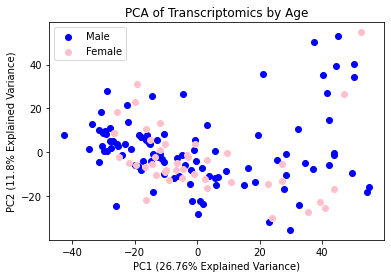

In [11]:
plt.scatter(maledf['PC1'], maledf['PC2'], label = 'Male', c='blue')
plt.scatter(femaledf['PC1'], femaledf['PC2'], label = 'Female', c='pink')
plt.legend()
plt.title("PCA of Transcriptomics by Age")
plt.xlabel('PC1 (' + str(round(pca.explained_variance_ratio_[0]*100, 2)) + '% Explained Variance)')
plt.ylabel('PC2 (' + str(round(pca.explained_variance_ratio_[1]*100, 2)) + '% Explained Variance)')
plt.savefig('results/GO_pca_by_sex.png')

In [12]:
principledf_withouthgps = principledf.iloc[:-10]
principledf_onlyhgps = principledf.iloc[-10:]

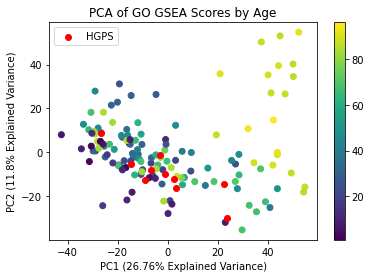

In [13]:
plt.scatter(principledf_withouthgps['PC1'], principledf_withouthgps['PC2'], c=principledf_withouthgps['age'], cmap='viridis')
plt.colorbar()
plt.scatter(principledf_onlyhgps['PC1'], principledf_onlyhgps['PC2'], c='red', label = 'HGPS')
plt.title("PCA of GO GSEA Scores by Age")
plt.xlabel('PC1 (' + str(round(pca.explained_variance_ratio_[0]*100, 2)) + '% Explained Variance)')
plt.ylabel('PC2 (' + str(round(pca.explained_variance_ratio_[1]*100, 2)) + '% Explained Variance)')
plt.legend()
plt.savefig('results/GO_pca_by_age.png')

In [14]:
pd.DataFrame(pca.components_.T, index=control_df.columns, columns=["PC1","PC2"]).sort_values("PC1",ascending=False).to_csv("data/KEGG_GSEA_PCA.csv")

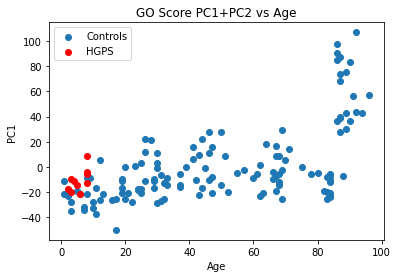

In [15]:
plt.scatter(principledf_withouthgps['age'], principledf_withouthgps['PC1']+principledf_withouthgps['PC2'], label = "Controls")
plt.scatter(principledf_onlyhgps['age'], principledf_onlyhgps['PC1']+principledf_onlyhgps['PC2'], c = 'red', label = "HGPS")
plt.xlabel('Age')
plt.ylabel('PC1')
plt.title("GO Score PC1+PC2 vs Age")
plt.legend()
plt.savefig('results/GO_age_by_pc1+pc2.png')

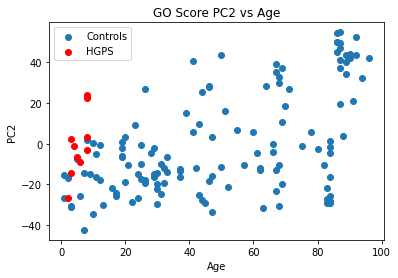

In [16]:
plt.scatter(principledf_withouthgps['age'], principledf_withouthgps['PC1'], label = "Controls")
plt.scatter(principledf_onlyhgps['age'], principledf_onlyhgps['PC1'], c = 'red', label = "HGPS")
plt.xlabel('Age')
plt.ylabel('PC2')
plt.title("GO Score PC2 vs Age")
plt.legend()
plt.savefig('results/GO_age_by_pc1.png')

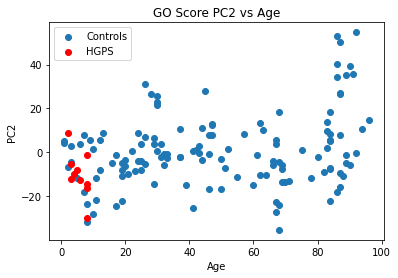

In [17]:
plt.scatter(principledf_withouthgps['age'], principledf_withouthgps['PC2'], label = "Controls")
plt.scatter(principledf_onlyhgps['age'], principledf_onlyhgps['PC2'], c = 'red', label = "HGPS")
plt.xlabel('Age')
plt.ylabel('PC2')
plt.title("GO Score PC2 vs Age")
plt.legend()
plt.savefig('results/GO_age_by_pc2.png')

In [ ]:
from scipy import stats 

In [ ]:
stats.spearmanr(principledf_withouthgps['age'], principledf_withouthgps['PC1']+principledf_withouthgps['PC2'])

SpearmanrResult(correlation=0.605002761747505, pvalue=1.2325591820005399e-14)

In [ ]:
control_df

Term|NES,'de novo' posttranslational protein folding (GO:0051084),3'-phosphoadenosine 5'-phosphosulfate metabolic process (GO:0050427),7-methylguanosine RNA capping (GO:0009452),7-methylguanosine mRNA capping (GO:0006370),ATP generation from ADP (GO:0006757),ATP metabolic process (GO:0046034),ATP-dependent chromatin remodeling (GO:0043044),B cell activation (GO:0042113),B cell differentiation (GO:0030183),B cell proliferation (GO:0042100),B cell receptor signaling pathway (GO:0050853),BMP signaling pathway (GO:0030509),C-terminal protein amino acid modification (GO:0018410),C-terminal protein lipidation (GO:0006501),C21-steroid hormone metabolic process (GO:0008207),CENP-A containing chromatin organization (GO:0061641),CENP-A containing nucleosome assembly (GO:0034080),COPII vesicle coating (GO:0048208),COPII-coated vesicle budding (GO:0090114),DNA alkylation (GO:0006305),DNA biosynthetic process (GO:0071897),"DNA catabolic process, endonucleolytic (GO:0000737)",DNA damage checkpoint (GO:0000077),"DNA damage response, signal transduction by p53 class mediator (GO:0030330)","DNA damage response, signal transduction by p53 class mediator resulting in cell cycle arrest (GO:0006977)",DNA duplex unwinding (GO:0032508),DNA geometric change (GO:0032392),DNA metabolic process (GO:0006259),DNA methylation (GO:0006306),DNA methylation or demethylation (GO:0044728),DNA recombination (GO:0006310),DNA repair (GO:0006281),DNA replication (GO:0006260),DNA replication checkpoint (GO:0000076),DNA replication initiation (GO:0006270),DNA replication-independent nucleosome assembly (GO:0006336),DNA strand elongation involved in DNA replication (GO:0006271),DNA synthesis involved in DNA repair (GO:0000731),DNA-dependent DNA replication (GO:0006261),DNA-dependent DNA replication maintenance of fidelity (GO:0045005),...,ureteric bud development (GO:0001657),ureteric bud morphogenesis (GO:0060675),urogenital system development (GO:0001655),vacuolar acidification (GO:0007035),vacuolar transport (GO:0007034),vascular endothelial growth factor receptor signaling pathway (GO:0048010),vasculogenesis (GO:0001570),ventricular cardiac muscle tissue development (GO:0003229),ventricular cardiac muscle tissue morphogenesis (GO:0055010),ventricular septum development (GO:0003281),ventricular septum morphogenesis (GO:0060412),very long-chain fatty acid metabolic process (GO:0000038),vesicle coating (GO:0006901),vesicle cytoskeletal trafficking (GO:0099518),vesicle docking (GO:0048278),vesicle fusion (GO:0006906),vesicle organization (GO:0016050),"vesicle targeting, rough ER to cis-Golgi (GO:0048207)",vesicle transport along microtubule (GO:0047496),vesicle-mediated transport (GO:0016192),vesicle-mediated transport between endosomal compartments (GO:0098927),vesicle-mediated transport in synapse (GO:0099003),vesicle-mediated transport to the plasma membrane (GO:0098876),viral budding (GO:0046755),viral budding via host ESCRT complex (GO:0039702),viral entry into host cell (GO:0046718),viral gene expression (GO:0019080),viral genome replication (GO:0019079),viral life cycle (GO:0019058),viral process (GO:0016032),viral transcription (GO:0019083),visual perception (GO:0007601),vitamin transport (GO:0051180),water-soluble vitamin metabolic process (GO:0006767),wound healing (GO:0042060),"wound healing, spreading of cells (GO:0044319)",zinc II ion transmembrane transport (GO:0071577),zinc II ion transport (GO:0006829),zinc ion homeostasis (GO:0055069),zymogen activation (GO:0031638)
101_19yr_Female_Caucasian,0.35089,0.055188,0.386474,0.386474,0.14217,0.247572,0.379751,-0.118206,-0.108893,-0.276864,-0.133898,0.0700842,-0.104656,-0.111703,-0.0495558,0.27877,0.27877,0.360908,0.35355,0.132912,0.161734,0.155329,0.203754,0.243642,0.289547,0.309873,0.211489,0.24768,0.108512,0.132912,0.189237,0.233408,0.238855,0.159788,0.251949,0.279988,0.31233,0.240671,0.256804,0.186717,...,-0.102307,-0.0335728,-0.00687992,0.245358,0.245741,0.208922,0.131619,-0.0892029,0.0600064,0.107914,0.1

In [ ]:
X

Term|NES,'de novo' posttranslational protein folding (GO:0051084),3'-phosphoadenosine 5'-phosphosulfate metabolic process (GO:0050427),7-methylguanosine RNA capping (GO:0009452),7-methylguanosine mRNA capping (GO:0006370),ATP generation from ADP (GO:0006757),ATP metabolic process (GO:0046034),ATP-dependent chromatin remodeling (GO:0043044),B cell activation (GO:0042113),B cell differentiation (GO:0030183),B cell proliferation (GO:0042100),B cell receptor signaling pathway (GO:0050853),BMP signaling pathway (GO:0030509),C-terminal protein amino acid modification (GO:0018410),C-terminal protein lipidation (GO:0006501),C21-steroid hormone metabolic process (GO:0008207),CENP-A containing chromatin organization (GO:0061641),CENP-A containing nucleosome assembly (GO:0034080),COPII vesicle coating (GO:0048208),COPII-coated vesicle budding (GO:0090114),DNA alkylation (GO:0006305),DNA biosynthetic process (GO:0071897),"DNA catabolic process, endonucleolytic (GO:0000737)",DNA damage checkpoint (GO:0000077),"DNA damage response, signal transduction by p53 class mediator (GO:0030330)","DNA damage response, signal transduction by p53 class mediator resulting in cell cycle arrest (GO:0006977)",DNA duplex unwinding (GO:0032508),DNA geometric change (GO:0032392),DNA metabolic process (GO:0006259),DNA methylation (GO:0006306),DNA methylation or demethylation (GO:0044728),DNA recombination (GO:0006310),DNA repair (GO:0006281),DNA replication (GO:0006260),DNA replication checkpoint (GO:0000076),DNA replication initiation (GO:0006270),DNA replication-independent nucleosome assembly (GO:0006336),DNA strand elongation involved in DNA replication (GO:0006271),DNA synthesis involved in DNA repair (GO:0000731),DNA-dependent DNA replication (GO:0006261),DNA-dependent DNA replication maintenance of fidelity (GO:0045005),...,ureteric bud development (GO:0001657),ureteric bud morphogenesis (GO:0060675),urogenital system development (GO:0001655),vacuolar acidification (GO:0007035),vacuolar transport (GO:0007034),vascular endothelial growth factor receptor signaling pathway (GO:0048010),vasculogenesis (GO:0001570),ventricular cardiac muscle tissue development (GO:0003229),ventricular cardiac muscle tissue morphogenesis (GO:0055010),ventricular septum development (GO:0003281),ventricular septum morphogenesis (GO:0060412),very long-chain fatty acid metabolic process (GO:0000038),vesicle coating (GO:0006901),vesicle cytoskeletal trafficking (GO:0099518),vesicle docking (GO:0048278),vesicle fusion (GO:0006906),vesicle organization (GO:0016050),"vesicle targeting, rough ER to cis-Golgi (GO:0048207)",vesicle transport along microtubule (GO:0047496),vesicle-mediated transport (GO:0016192),vesicle-mediated transport between endosomal compartments (GO:0098927),vesicle-mediated transport in synapse (GO:0099003),vesicle-mediated transport to the plasma membrane (GO:0098876),viral budding (GO:0046755),viral budding via host ESCRT complex (GO:0039702),viral entry into host cell (GO:0046718),viral gene expression (GO:0019080),viral genome replication (GO:0019079),viral life cycle (GO:0019058),viral process (GO:0016032),viral transcription (GO:0019083),visual perception (GO:0007601),vitamin transport (GO:0051180),water-soluble vitamin metabolic process (GO:0006767),wound healing (GO:0042060),"wound healing, spreading of cells (GO:0044319)",zinc II ion transmembrane transport (GO:0071577),zinc II ion transport (GO:0006829),zinc ion homeostasis (GO:0055069),zymogen activation (GO:0031638)
0,0.35089,0.055188,0.386474,0.386474,0.14217,0.247572,0.379751,-0.118206,-0.108893,-0.276864,-0.133898,0.0700842,-0.104656,-0.111703,-0.0495558,0.27877,0.27877,0.360908,0.35355,0.132912,0.161734,0.155329,0.203754,0.243642,0.289547,0.309873,0.211489,0.24768,0.108512,0.132912,0.189237,0.233408,0.238855,0.159788,0.251949,0.279988,0.31233,0.240671,0.256804,0.186717,...,-0.102307,-0.0335728,-0.00687992,0.245358,0.245741,0.208922,0.131619,-0.0892029,0.0600064,0.107914,0.147814,0.124705,0.360908,

In [ ]:
X

Term|NES,'de novo' posttranslational protein folding (GO:0051084),3'-phosphoadenosine 5'-phosphosulfate metabolic process (GO:0050427),7-methylguanosine RNA capping (GO:0009452),7-methylguanosine mRNA capping (GO:0006370),ATP generation from ADP (GO:0006757),ATP metabolic process (GO:0046034),ATP-dependent chromatin remodeling (GO:0043044),B cell activation (GO:0042113),B cell differentiation (GO:0030183),B cell proliferation (GO:0042100),B cell receptor signaling pathway (GO:0050853),BMP signaling pathway (GO:0030509),C-terminal protein amino acid modification (GO:0018410),C-terminal protein lipidation (GO:0006501),C21-steroid hormone metabolic process (GO:0008207),CENP-A containing chromatin organization (GO:0061641),CENP-A containing nucleosome assembly (GO:0034080),COPII vesicle coating (GO:0048208),COPII-coated vesicle budding (GO:0090114),DNA alkylation (GO:0006305),DNA biosynthetic process (GO:0071897),"DNA catabolic process, endonucleolytic (GO:0000737)",DNA damage checkpoint (GO:0000077),"DNA damage response, signal transduction by p53 class mediator (GO:0030330)","DNA damage response, signal transduction by p53 class mediator resulting in cell cycle arrest (GO:0006977)",DNA duplex unwinding (GO:0032508),DNA geometric change (GO:0032392),DNA metabolic process (GO:0006259),DNA methylation (GO:0006306),DNA methylation or demethylation (GO:0044728),DNA recombination (GO:0006310),DNA repair (GO:0006281),DNA replication (GO:0006260),DNA replication checkpoint (GO:0000076),DNA replication initiation (GO:0006270),DNA replication-independent nucleosome assembly (GO:0006336),DNA strand elongation involved in DNA replication (GO:0006271),DNA synthesis involved in DNA repair (GO:0000731),DNA-dependent DNA replication (GO:0006261),DNA-dependent DNA replication maintenance of fidelity (GO:0045005),...,ureteric bud development (GO:0001657),ureteric bud morphogenesis (GO:0060675),urogenital system development (GO:0001655),vacuolar acidification (GO:0007035),vacuolar transport (GO:0007034),vascular endothelial growth factor receptor signaling pathway (GO:0048010),vasculogenesis (GO:0001570),ventricular cardiac muscle tissue development (GO:0003229),ventricular cardiac muscle tissue morphogenesis (GO:0055010),ventricular septum development (GO:0003281),ventricular septum morphogenesis (GO:0060412),very long-chain fatty acid metabolic process (GO:0000038),vesicle coating (GO:0006901),vesicle cytoskeletal trafficking (GO:0099518),vesicle docking (GO:0048278),vesicle fusion (GO:0006906),vesicle organization (GO:0016050),"vesicle targeting, rough ER to cis-Golgi (GO:0048207)",vesicle transport along microtubule (GO:0047496),vesicle-mediated transport (GO:0016192),vesicle-mediated transport between endosomal compartments (GO:0098927),vesicle-mediated transport in synapse (GO:0099003),vesicle-mediated transport to the plasma membrane (GO:0098876),viral budding (GO:0046755),viral budding via host ESCRT complex (GO:0039702),viral entry into host cell (GO:0046718),viral gene expression (GO:0019080),viral genome replication (GO:0019079),viral life cycle (GO:0019058),viral process (GO:0016032),viral transcription (GO:0019083),visual perception (GO:0007601),vitamin transport (GO:0051180),water-soluble vitamin metabolic process (GO:0006767),wound healing (GO:0042060),"wound healing, spreading of cells (GO:0044319)",zinc II ion transmembrane transport (GO:0071577),zinc II ion transport (GO:0006829),zinc ion homeostasis (GO:0055069),zymogen activation (GO:0031638)
0,0.35089,0.055188,0.386474,0.386474,0.14217,0.247572,0.379751,-0.118206,-0.108893,-0.276864,-0.133898,0.0700842,-0.104656,-0.111703,-0.0495558,0.27877,0.27877,0.360908,0.35355,0.132912,0.161734,0.155329,0.203754,0.243642,0.289547,0.309873,0.211489,0.24768,0.108512,0.132912,0.189237,0.233408,0.238855,0.159788,0.251949,0.279988,0.31233,0.240671,0.256804,0.186717,...,-0.102307,-0.0335728,-0.00687992,0.245358,0.245741,0.208922,0.131619,-0.0892029,0.0600064,0.107914,0.147814,0.124705,0.360908,

In [ ]:
j=20
feature_selection=SelectKBest(mutual_info_regression, k=j)
X_new=feature_selection.fit_transform(X.to_numpy(), y)

In [ ]:
r=[]
loo=LeaveOneOut()
X=control_df
X=X.reset_index()
X=X.drop(["index"], axis=1)
labels = list(control_df.index)
control_ages = [int(label.lower().split('_')[1].split('y')[0]) for label in labels]
y=np.array(control_ages)


for j in np.linspace(300,500,50):
  # m=dict()
  # m["k"]=k
  feature_selection=SelectKBest(mutual_info_regression,k=int(j))
  X_new=feature_selection.fit_transform(X.copy(), y)
  y_pred=[]
  y_act=[]
  print(k)
  for train_index, test_index in loo.split(X_new):
    X_train, X_test = X_new[train_index], X_new[test_index]
    n_genes.append(X_train.shape[1])
    y_train, y_test = y[train_index], y[test_index]
    reg=LinearRegression().fit(X_train,y_train)
    y_pred.append(reg.predict(X_test))
    y_act.append(y_test)
  y_pred = np.array([y[0] for y in y_pred])
  y_act = np.array([y[0] for y in y_act])
  r2, p = pearsonr((y_act),(y_pred))
  r.append(r2)

2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0


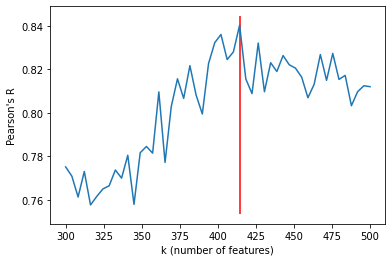

In [ ]:
plt.plot(np.linspace(300,500,50),r)
plt.xlabel("k (number of features)")
plt.ylabel("Pearson's R")
plt.vlines(np.linspace(300,500,50)[np.argmax(r)], plt.ylim()[0], plt.ylim()[1], color="red")
plt.savefig("results/feature_selection_GO.png")

In [19]:
from sklearn import linear_model

In [20]:
X=control_df
X=X.reset_index()
X=X.drop(["index"], axis=1)
loo=LeaveOneOut()
labels = list(control_df.index)
control_ages = [int(label.lower().split('_')[1].split('y')[0]) for label in labels]
y=np.array(control_ages)
feature_selection=SelectKBest(mutual_info_regression,k=int(414))
X_new=feature_selection.fit_transform(X.copy(), y)
y_pred=[]
y_act=[]
n_genes=[]
for train_index, test_index in loo.split(X_new):
  X_train, X_test = X_new[train_index], X_new[test_index]
  n_genes.append(X_train.shape[1])
  y_train, y_test = y[train_index], y[test_index]
  reg=linear_model.LinearRegression().fit(X_train,y_train)
  y_pred.append(reg.predict(X_test))
  y_act.append(y_test)
y_pred = np.array([y[0] for y in y_pred])
y_act = np.array([y[0] for y in y_act])
r2, p = pearsonr((y_act),(y_pred))

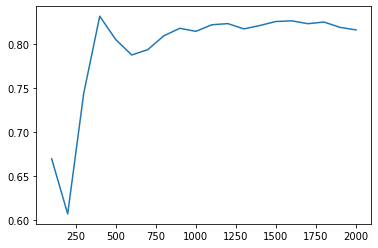

In [ ]:
plt.plot(np.linspace(100,2000,20),r)

In [ ]:
import sklearn

In [ ]:
sklearn.metrics.r2_score(y_act,y_pred)

0.6119772188957506

In [ ]:
import seaborn as sns

In [ ]:
np.median(np.abs(y_act-y_pred))

12.313880884681076

R2: 0.824
p: 3.6938840323982087e-34


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(10, 90, '$R^2$=0.679')

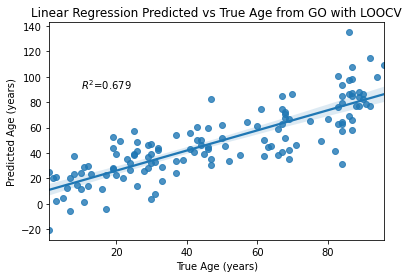

In [ ]:
sns.regplot(y_act,y_pred)
r2, p = pearsonr((y_act),(y_pred))
print("R2: " + str(round(r2, 3)))
print("p: " + str(p))
plt.xlabel('True Age (years)')
plt.ylabel('Predicted Age (years)')
plt.title("Linear Regression Predicted vs True Age from GO with LOOCV")
plt.text(10,90,s="$R^2$=" + str(round(r2**2, 3)))

In [33]:
feature_selection=SelectKBest(mutual_info_regression,k=500)
X_new=feature_selection.fit_transform(X.copy(), y)

In [34]:
reg=LinearRegression().fit(X_new,y)
t=feature_selection.get_support()
a=[x[0] for x in zip(list(control_df.columns),list(t)) if x[1]]
features=pd.DataFrame([a,reg.coef_]).T.sort_values(by=1, ascending=False)
features=features.set_index(0)


In [35]:
features

,1
0,
negative regulation of cytokine secretion (GO:0050710),263.859
regulation of epidermal cell differentiation (GO:0045604),260.697
negative regulation of transcription regulatory region DNA binding (GO:2000678),225.684
regulation of ubiquitin protein ligase activity (GO:1904666),206.308
regulation of developmental growth (GO:0048638),205.515
...,...
regulation of plasma membrane bounded cell projection assembly (GO:0120032),-185.427
negative regulation of Notch signaling pathway (GO:0045746),-202.973
regulation of synaptic vesicle exocytosis (GO:2000300),-207.797


In [37]:
features.to_csv("GO_GSEA_features.csv")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


R2: 0.813
p: 1.450308290772625e-32


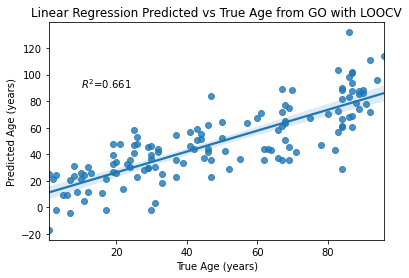

In [ ]:
sns.regplot(y_act,y_pred)
r2, p = pearsonr((y_act),(y_pred))
print("R2: " + str(round(r2, 3)))
print("p: " + str(p))
plt.xlabel('True Age (years)')
plt.ylabel('Predicted Age (years)')
plt.title("Linear Regression Predicted vs True Age from GO with LOOCV")
plt.text(10,90,s="$R^2$=" + str(round(r2**2, 3)))
plt.savefig('results/GO_pred_true_age_linreg.png')

In [ ]:
np.median(np.abs(np.array(y_act)-np.array(y_pred)))

12.423811546310255

In [ ]:
r2, p = pearsonr((y_act),(y_pred))
print("R2: " + str(round(r2, 3)))
print("p: " + str(p))

R2: 0.821
p: 1.098794941171154e-33


PCA on Controls Only

In [ ]:
labels = control_df.index
ages = [int(label.lower().split('_')[1].split('y')[0]) for label in labels]
sex = [int(label.lower().split('_')[2] == 'male') for label in labels]
race = [label.lower().split('_')[3] for label in labels]

Text(0, 0.5, 'PC2 (12.07% Explained Variance)')

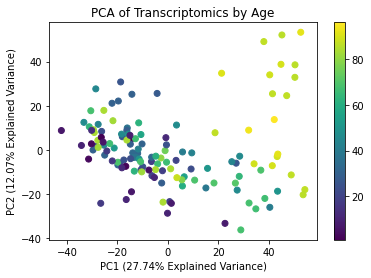

In [ ]:
total_numpy = control_df.to_numpy()
pca = PCA(n_components=2)
scaler = StandardScaler()
x = scaler.fit_transform(total_numpy)
principlecomponents = pca.fit_transform(x)
principledf = pd.DataFrame(principlecomponents)
principledf.columns = ['PC1', 'PC2']
principledf['age'] = ages
principledf['sex'] = sex
plt.scatter(principledf['PC1'], principledf['PC2'], c=principledf['age'], cmap='viridis')
plt.colorbar()
plt.title("PCA of Transcriptomics by Age")
plt.xlabel('PC1 (' + str(round(pca.explained_variance_ratio_[0]*100, 2)) + '% Explained Variance)')
plt.ylabel('PC2 (' + str(round(pca.explained_variance_ratio_[1]*100, 2)) + '% Explained Variance)')

In [ ]:
ls=pd.DataFrame(pca.components_.T, index=control_df.columns, columns=["PC1","PC2"]).sort_values("PC1",ascending=False)

In [ ]:
l=list(ls.iloc[0:10,:].index)
l.extend(ls.iloc[-10:,:].index)

In [ ]:
print(len(l))

20


In [ ]:
l

['Autophagy',
 'Mitophagy',
 'HIF-1 signaling pathway',
 'Longevity regulating pathway',
 'Kaposi sarcoma-associated herpesvirus infection',
 'Relaxin signaling pathway',
 'Insulin resistance',
 'Endocytosis',
 'Choline metabolism in cancer',
 'Chagas disease (American trypanosomiasis)',
 'Nucleotide excision repair',
 'Olfactory transduction',
 'Oocyte meiosis',
 'Homologous recombination',
 'Progesterone-mediated oocyte maturation',
 'Mismatch repair',
 'Cell cycle',
 'Fanconi anemia pathway',
 'DNA replication',
 'Base excision repair']

In [ ]:
control_df[l]

Term|NES,Autophagy,Mitophagy,HIF-1 signaling pathway,Longevity regulating pathway,Kaposi sarcoma-associated herpesvirus infection,Relaxin signaling pathway,Insulin resistance,Endocytosis,Choline metabolism in cancer,Chagas disease (American trypanosomiasis),Nucleotide excision repair,Olfactory transduction,Oocyte meiosis,Homologous recombination,Progesterone-mediated oocyte maturation,Mismatch repair,Cell cycle,Fanconi anemia pathway,DNA replication,Base excision repair
101_19yr_Female_Caucasian,0.300811,0.411481,0.227139,0.204395,0.196937,0.200184,0.170613,0.306391,0.181186,0.162133,0.374306,-0.466854,0.212418,0.204449,0.197461,0.352004,0.338167,0.167523,0.380181,0.335416
102_19yr_Male_Caucasian,0.318589,0.424795,0.227692,0.217506,0.190726,0.206926,0.184469,0.319902,0.195259,0.168162,0.374638,-0.472225,0.222099,0.207284,0.21136,0.359253,0.339376,0.171746,0.385038,0.344981
103_19yr_Male_Caucasian,0.310864,0.419004,0.215251,0.206352,0.192528,0.20241,0.183477,0.314983,0.190353,0.164489,0.359942,-0.468985,0.214542,0.177954,0.205075,0.321764,0.327787,0.14887,0.344135,0.33183
104_19yr_Male_Caucasian,0.307579,0.413091,0.222795,0.209611,0.190155,0.201233,0.179122,0.307939,0.188177,0.155092,0.362781,-0.469243,0.214945,0.179361,0.203729,0.321781,0.324957,0.159208,0.350371,0.337408
105_20yr_Male_Caucasian,0.300494,0.41328,0.21956,0.199187,0.19651,0.19613,0.175976,0.300295,0.181119,0.169072,0.381704,-0.469114,0.23011,0.211272,0.215749,0.367113,0.354675,0.186415,0.399525,0.353755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94_12_male_Caucasian,0.312557,0.41872,0.222888,0.204805,0.194367,0.200596,0.181917,0.303565,0.180326,0.161373,0.392884,-0.463526,0.223794,0.217509,0.215309,0.377033,0.35103,0.183269,0.402608,0.344205
95_13yr_Male_WhiTEEASTINDIAN,0.300575,0.405592,0.219269,0.196842,0.197052,0.195314,0.169657,0.298438,0.179672,0.157685,0.395409,-0.460509,0.233229,0.229059,0.220136,0.378487,0.356486,0.198683,0.407578,0.356599
97_16yr_Female_Unknown,0.29865,0.410233,0.221333,0.197442,0.196238,0.200444,0.163776,0.298174,0.182767,0.162942,0.385211,-0.466001,0.230549,0.220814,0.216782,0.377766,0.356609,0.191912,0.404684,0.347971
98_17yr_Male_Caucasian,0.287317,0.395167,0.205157,0.191053,0.177813,0.191265,0.159939,0.29542,0.167606,0.154068,0.371856,-0.459315,0.208408,0.190576,0.199139,0.345687,0.322209,0.163574,0.369164,0.354881


In [ ]:
loo=LeaveOneOut()
X=control_df[l]
X=X.reset_index()
X=X.drop(["index"], axis=1)
labels = list(control_df.index)
control_ages = [int(label.lower().split('_')[1].split('y')[0]) for label in labels]
y=np.array(control_ages)
n_genes=[]
y_pred=[]
y_act=[]
for train_index, test_index in loo.split(X):
  X_train, X_test = X.loc[train_index], X.loc[test_index]
  n_genes.append(X_train.shape[1])
  y_train, y_test = y[train_index], y[test_index]
  reg=LinearRegression().fit(X_train,y_train)
  y_pred.append(reg.predict(X_test))
  y_act.append(y_test)
y_pred = np.array([y[0] for y in y_pred])
y_act = np.array([y[0] for y in y_act])

In [ ]:
loo=LeaveOneOut()
X=control_df
X=X.reset_index()
X=X.drop(["index"], axis=1)
labels = list(control_df.index)
control_ages = [int(label.lower().split('_')[1].split('y')[0]) for label in labels]
y=np.array(control_ages)
n_genes=[]
y_pred=[]
y_act=[]
for train_index, test_index in loo.split(X):
  X_train, X_test = X.loc[train_index], X.loc[test_index]
  n_genes.append(X_train.shape[1])
  y_train, y_test = y[train_index], y[test_index]
  reg=svm.SVR(kernel='linear').fit(X_train,y_train)
  y_pred.append(reg.predict(X_test))
  y_act.append(y_test)
y_pred = np.array([y[0] for y in y_pred])
y_act = np.array([y[0] for y in y_act])

KeyboardInterrupt: ignored

In [ ]:
r2, p = pearsonr(y_act,y_pred)
print("R2: " + str(round(r2, 3)))
print("p: " + str(p))

R2: 0.566
p: 1.2383557790537062e-12


In [ ]:
def make_labels(y,K):
  classifiers_ranges=get_ranges(y,K)
  y_mod=[]
  classifier_classes=np.zeros((K,len(y)))
  for i in range(K):
    for j in range(len(y)):
      for k in range(len(classifiers_ranges[i])):
        if y[j] in classifiers_ranges[i][k]:
          classifier_classes[i,j]=k
          break
  return classifier_classes, classifiers_ranges


In [ ]:
def get_ranges(y,K):
  classifiers_ranges=[]
  for i in range(K):
    classifier_ranges=[]
    classifier_ranges.append(list(range(0,i+1)))
    j=i+1
    while j<y.max():
      classifier_ranges.append(list(range(j,j+K+1)))
      j+=K+1
    classifiers_ranges.append(classifier_ranges)
  return classifiers_ranges

In [ ]:
def ensemble_voting(X_train,y_train,X_test,K):
  y_trans, classifiers_ranges=make_labels(y_train,K)
  y_pred_cat=[]
  for i in range(len(y_trans)):
    clf = LinearDiscriminantAnalysis(solver="eigen", shrinkage="auto")
    # clf= SVC(kernel='poly')
    clf.fit(X_train, y_trans[i])
    y_pred_cat.extend(classifiers_ranges[i][int(clf.predict([X_test])[0])])
  d=dict(collections.Counter(y_pred_cat))
  return max(d.items(),key=operator.itemgetter(1))[0]

  


In [ ]:
def loocv(X, y, K):
  loo=LeaveOneOut()
  n_genes=[]
  y_pred=[]
  y_act=[]
  i=0
  for train_index, test_index in loo.split(X):
    i+=1
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    n_genes.append(X_train.shape[1])
    y_train, y_test = y[train_index], y[test_index]
    y_pred.append(ensemble_voting(X_train,y_train,X_test.iloc[0],K))
    y_act.append(y_test[0])
    print(i,y_pred[-1],y_test[0])
  return y_pred, y_act

In [ ]:

X=control_df
X=X.reset_index()
X=X.drop(["index"], axis=1)
labels = list(control_df.index)
control_ages = [int(label.lower().split('_')[1].split('y')[0]) for label in labels]
y=np.array(control_ages)
y_pred, y_act=loocv(X,y,20)

/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_shrunk_covariance.py:205: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_empirical_covariance.py:75: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "


1 30 19


/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_shrunk_covariance.py:205: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_empirical_covariance.py:75: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "


2 20 19


/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_shrunk_covariance.py:205: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_empirical_covariance.py:75: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "


3 19 19


/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_shrunk_covariance.py:205: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_empirical_covariance.py:75: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "


4 23 19


/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_shrunk_covariance.py:205: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_empirical_covariance.py:75: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "


5 19 20


/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_shrunk_covariance.py:205: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_empirical_covariance.py:75: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "


6 31 20


/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_shrunk_covariance.py:205: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_empirical_covariance.py:75: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "


7 24 31


/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_shrunk_covariance.py:205: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_empirical_covariance.py:75: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "


8 31 31


/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_shrunk_covariance.py:205: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_empirical_covariance.py:75: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "


9 25 32


/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_shrunk_covariance.py:205: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_empirical_covariance.py:75: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "


10 66 32


/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_shrunk_covariance.py:205: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_empirical_covariance.py:75: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "


11 12 33


/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_shrunk_covariance.py:205: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_empirical_covariance.py:75: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "


12 24 33


/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_shrunk_covariance.py:205: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_empirical_covariance.py:75: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "


13 33 37


/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_shrunk_covariance.py:205: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_empirical_covariance.py:75: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "


14 32 37


/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_shrunk_covariance.py:205: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_empirical_covariance.py:75: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "


15 70 37


/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_shrunk_covariance.py:205: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_empirical_covariance.py:75: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "


16 69 39


/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_shrunk_covariance.py:205: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_empirical_covariance.py:75: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "


17 64 51


/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_shrunk_covariance.py:205: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_empirical_covariance.py:75: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "


18 32 52


/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_shrunk_covariance.py:205: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_empirical_covariance.py:75: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "


19 57 55


/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_shrunk_covariance.py:205: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_empirical_covariance.py:75: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "


20 43 57


/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_shrunk_covariance.py:205: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_empirical_covariance.py:75: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "


21 76 60


/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_shrunk_covariance.py:205: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_empirical_covariance.py:75: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "


22 41 71


/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_shrunk_covariance.py:205: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_empirical_covariance.py:75: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "


23 57 75


/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_shrunk_covariance.py:205: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_empirical_covariance.py:75: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "


24 69 78


/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_shrunk_covariance.py:205: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_empirical_covariance.py:75: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "


25 31 80


/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_shrunk_covariance.py:205: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_empirical_covariance.py:75: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_shrunk_covariance.py:205: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_empirical_covariance.py:75: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_shrunk_covariance.py:205: UserWarning: Only one sample available. You may want to reshape you

26 89 94


/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_shrunk_covariance.py:205: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_empirical_covariance.py:75: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "


27 87 89


/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_shrunk_covariance.py:205: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_empirical_covariance.py:75: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "


28 87 87


/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_shrunk_covariance.py:205: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_empirical_covariance.py:75: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "


29 87 90


/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_shrunk_covariance.py:205: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_empirical_covariance.py:75: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "


30 87 89


/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_shrunk_covariance.py:205: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_empirical_covariance.py:75: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "


31 87 86


/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_shrunk_covariance.py:205: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_empirical_covariance.py:75: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "


32 90 92


/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_shrunk_covariance.py:205: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_empirical_covariance.py:75: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "


33 90 87


/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_shrunk_covariance.py:205: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_empirical_covariance.py:75: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_shrunk_covariance.py:205: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_empirical_covariance.py:75: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "


34 29 1


/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_shrunk_covariance.py:205: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_empirical_covariance.py:75: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "


35 32 12


/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_shrunk_covariance.py:205: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_empirical_covariance.py:75: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "


36 24 22


/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_shrunk_covariance.py:205: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_empirical_covariance.py:75: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "


37 16 25


/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_shrunk_covariance.py:205: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_empirical_covariance.py:75: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "


38 20 29


/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_shrunk_covariance.py:205: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_empirical_covariance.py:75: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "


39 29 24


KeyboardInterrupt: ignored

In [ ]:
plt.scatter(y_act,y_pred)
plt.legend()
plt.xlabel('True Age (years)')
plt.ylabel('Predicted Age (years)')
plt.title("Linear Regression Predicted vs True Age with LOOCV")

NameError: ignored

In [ ]:
r2, p = pearsonr(y_act,y_pred)
print("R2: " + str(round(r2, 3)))
print("p: " + str(p))

R2: 0.772
p: 1.6491049024778758e-27


In [ ]:
r2, p = pearsonr(y_act,y_pred)
print("R2: " + str(round(r2, 3)))
print("p: " + str(p))

R2: 0.676
p: 4.290127614258719e-19


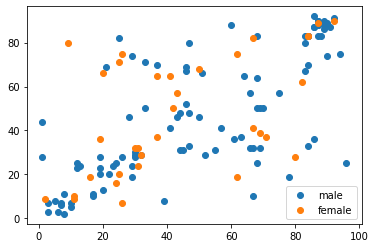

In [ ]:
male=[(x[0], x[1]) for x in zip(y_act,y_pred,sex) if x[2]==1]
female=[(x[0], x[1]) for x in zip(y_act,y_pred,sex) if x[2]==0]
plt.scatter([x[0] for x in male], [x[1] for x in male], label="male")
plt.scatter([x[0] for x in female], [x[1] for x in female], label="female")
plt.legend()

In [ ]:
np.mean([np.abs(x[0]-x[1]) for x in zip(y_act,y_pred,sex) if x[2]==1])

14.363636363636363

In [ ]:
np.mean([np.abs(x[0]-x[1]) for x in zip(y_act,y_pred,sex) if x[2]==0])

18.176470588235293

In [ ]:
import scip

In [ ]:
stats.ttest_ind([np.abs(x[0]-x[1]) for x in zip(y_act,y_pred,sex) if x[2]==1],[np.abs(x[0]-x[1]) for x in zip(y_act,y_pred,sex) if x[2]==0])

Ttest_indResult(statistic=-1.1282424070758765, pvalue=0.26127961289658336)

Binarization

In [ ]:
def bhainerize(y, threshold):
  return [int(yi>threshold) for yi in y]

In [ ]:
from sklearn.linear_model

In [ ]:
thresholds=np.linspace(np.array(control_ages).min(),np.array(control_ages).max(),np.array(control_ages).max()-np.array(control_ages).min())
accuracies=[]
for threshold in thresholds:
  loo=LeaveOneOut()
  X=control_df
  X=X.reset_index()
  X=X.drop(["index"], axis=1)
  labels = list(control_df.index)
  control_ages = [int(label.lower().split('_')[1].split('y')[0]) for label in labels]
  y=np.array(bhainerize(np.array(control_ages),threshold))
  n_genes=[]
  y_pred=[]
  y_act=[]
  for train_index, test_index in loo.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    n_genes.append(X_train.shape[1])
    y_train, y_test = y[train_index], y[test_index]
    reg=LogisticRegression().fit(X_train,y_train)
    y_pred.append(reg.predict(X_test))
    y_act.append(y_test)
  y_pred = np.array([y[0] for y in y_pred])
  y_act = np.array([y[0] for y in y_act])
  accuracies.append(np.mean([int(x[0]==x[1]) for x in zip(y_pred,y_act) ]))
  print(accuracies[-1])

0.9849624060150376
0.9774436090225563
0.9624060150375939
0.9624060150375939
0.9548872180451128
0.9473684210526315
0.9323308270676691
0.9172932330827067
0.9097744360902256
0.8947368421052632
0.8796992481203008
0.8646616541353384
0.8571428571428571
0.8571428571428571
0.8571428571428571
0.849624060150376
0.8345864661654135
0.8345864661654135
0.8045112781954887
0.7894736842105263
0.7819548872180451
0.7744360902255639
0.7669172932330827
0.7518796992481203
0.7293233082706767
0.706766917293233
0.706766917293233
0.6992481203007519
0.6766917293233082
0.6616541353383458
0.6616541353383458
0.6842105263157895
0.6842105263157895
0.6842105263157895
0.6842105263157895
0.6842105263157895
0.6842105263157895
0.6842105263157895
0.6842105263157895
0.6842105263157895
0.6766917293233082
0.6992481203007519
0.706766917293233
0.6992481203007519
0.7142857142857143
0.6842105263157895
0.6842105263157895
0.6842105263157895
0.6842105263157895
0.6992481203007519
0.6992481203007519
0.706766917293233
0.706766917293233

ValueError: ignored

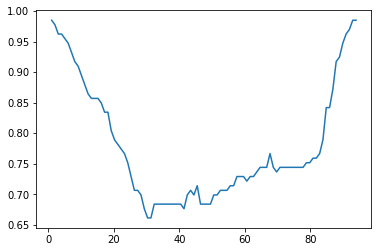

In [ ]:
plt.plot(thresholds[0:len(accuracies)], accuracies)